In [1]:
import numpy as np
import itertools
import datetime

import tensorflow as tf
import sklearn as sk

from gensim.models import Word2Vec

import Functions as fn
import Iterator as it
from DS import DS
from Set import pool
from FFModel import FF_Model
from RNNModel import RNN_Model

c:\users\luka\anaconda3\envs\tensorflow13\lib\site-packages\gensim\utils.py:865: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Data Loading

In [2]:
Dataset = pool()
Dataset.load_texts('raw_texts')
Dataset.load_labels('raw_labels')

Raw Text Load Complete
Raw Labels Load Complete


In [3]:
target_dict = fn.load_labels('final_meta/labels')

Label Load Complete


# Embedding Generation

In [4]:
train_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[:-10])
validation_set = pool(data=(Dataset.get_DS(stage='test', labelled='yes')).data[-10:])
test_set = Dataset.get_DS(stage='train', labelled='yes')
set_1 = Dataset.get_DS(stage='train', labelled='no')
set_2 = Dataset.get_DS(stage='test', labelled='no')
set_1.append(set_2.data)
set_1.append(train_set.data)
emb_set = set_1
print(emb_set.size, train_set.size, validation_set.size, test_set.size)

4585 238 10 10


In [5]:
#emb_set.process_for_embedding()
#sentences = emb_set.get_sentences()
#fn.write_sentences(sentences, 'final_meta/sentences')
sentences = fn.load_sentences('final_meta/sentences')

#model = Word2Vec(sentences, min_count=1, size=100)
#model.save('final_meta/W2V')
model = Word2Vec.load('final_meta/W2V')

vocab = model.wv.vocab.keys()

Sentence Load Complete


# Layer and Index Loading

In [6]:
#word_indices, emb_layer = fn.get_index_and_emb_layer(model)
#fn.write_word_indices(word_indices, 'final_meta/word_indices')
#fn.write_emb_layer(emb_layer, 'final_meta/emb_layer')

word_indices = fn.load_word_indices('final_meta/word_indices')
emb_layer = fn.load_emb_layer('final_meta/emb_layer')

Word Indices Load Complete
Embedding Layer Load Complete


# RNN Testing

In [7]:
target = 'do'

train_set.process_for_testing(target)
validation_set.process_for_testing(target)
test_set.process_for_testing(target)

lw, rw = 4, 4
sets = {}
sets['train_set'], sets['train_labels'], _, sets['train_lengths'] = train_set.get_rnn_sets(word_indices, lw, rw)
sets['validation_set'], sets['validation_labels'], _, sets['validation_lengths']= validation_set.get_rnn_sets(word_indices, lw, rw)
sets['test_set'], sets['test_labels'], sets['test_words'], sets['test_lengths'] = test_set.get_rnn_sets(word_indices, lw, rw)

In [8]:
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))
fn.saturate_training_set(sets, 0.1, seqlen=True)
print('Ratio: med: {:.2f}% non-med: {:.2f}%'.format(*(np.array(sets['train_labels']).sum(0)/ len(sets['train_labels']))))

Ratio: med: 0.03% non-med: 0.97%
Ratio: med: 0.11% non-med: 0.89%


c:\users\luka\anaconda3\envs\tensorflow13\lib\site-packages\tensorflow\python\ops\gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


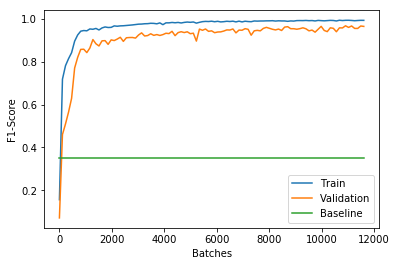

FInal Values: Tr-F1: 0.9942, Val-F1: 0.9660
Test F1-Score: 0.9225



In [9]:
RNN = RNN_Model(vocab_size=len(word_indices), state_size=100, num_classes=2, learn_rate=0.001, emb_layer=emb_layer)
RNN.build_graph()
results_list = RNN.train(sets=sets, epochs=2, batch=50, report_percentage=1, show_progress=True, show_plot=True)

In [10]:
res = RNN.predict(sets['test_set'], sets['test_lengths'])
tru = np.argmax(sets['test_labels'], 1)

In [12]:
token_perf = fn.token_perf(res, tru)

TP	TN	FP	FN
357	10744	32	28

Precision: 0.9177
Recall: 0.9273
F1-Score: 0.9225


In [13]:
baseline = [0 if word in target_dict['dosages'] else 1 for word in sets['test_words']]
sk.metrics.f1_score(tru, baseline, pos_label=0, average='binary')

0.35288414929714013

In [14]:
fn.category_words(sets['test_words'], res, tru, 1, 0)

of, three, kg, one, third, unit, dosed, for, level, less, than, <num>, <num>mg, low, dose, <num>mg, dose, <num>.<num>., halved, <num>, half, of, her, normal, dose, <num>, meq, ou


In [15]:
fn.colour_text(sets['test_words'], res, tru)

record #<num> <num> | tmh | <num> | | <num> | <num>/<num>/<num> <num>:<num>:<num> am | discharge summary | signed | dis | admission date <num>/<num>/<num> report status signed discharge date <num>/<num>/<num> history ms pizzo is a <num>-year-old woman with peripheral vascular disease who recently underwent revision of her left superior femoral artery anterior tibial bypass graft , who now presents with a cool , ischemic left foot mrs denman is a <num>-year-old , insulin-dependent diabetic with a long history of peripheral vascular disease as well as multiple surgical procedures she underwent a right transmetatarsal amputation in <num> and subsequently underwent a right femorla distal saphenous vein bypass graft in <num> which was later revised in <num>. she seems to be doing well with the left side until july of this year , at which time she underwent a left superficial femoral artery to anterior tibial artery bypass using non-reversed basilic vein harvested from the right arm she , ho

In [16]:
testers = Dataset.get_DS(stage='train', labelled='yes')
phrase_perf = fn.phrase_perf(target, RNN, testers, word_indices, side_words=[4, 4], show_phrases=True, case_info=True, rnn=True)

Name:  0101
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


<num> mg [34, 3] [34, 4] 100 mg [34, 3] [34, 4]
<num> units [34, 9] [35, 0] 12 units [34, 9] [35, 0]
sliding scale [35, 6] [36, 0] sliding scale [35, 6] [36, 0]
insulin scale [36, 2] [36, 3]
<num> mg [36, 6] [36, 7] 30 mg [36, 6] [36, 7]
<num> mg [36, 11] [36, 12] 5 mg [36, 11] [36, 12]
<num> mg [37, 3] [37, 4] 50 mg [37, 3] [37, 4]
<num> mg [37, 8] [37, 9] 150 mg [37, 8] [37, 9]
<num> mg [37, 13] [37, 14] 200 mg [37, 13] [37, 14]
<num> mg [38, 5] [38, 6] 225 mg [38, 5] [38, 6]
<num> mg [38, 11] [38, 12] 1250 mg [38, 11] [38, 12]
<num> mg [70, 3] [70, 4] 1250 mg [70, 3] [70, 4]
<num> mg [70, 10] [71, 0] 200 mg [70, 10] [71, 0]
<num> mg [73, 10] [73, 11] 10 mg [73, 10] [73, 11]
<num>-<num> tablets [74, 3] [74, 4] 1-2 tablets [74, 3] [74, 4]
<num> mg [74, 11] [74, 12] 100 mg [74, 11] [74, 12]
<num> units [75, 4] [75, 5] 10 units [75, 4] [75, 5]
sliding scale [75, 9] [75, 10]

<num>.<num> mg [19, 1] [19, 2] 2.5 mg [19, 1] [19, 2]
<num> mg [20, 1] [20, 2] 10 mg [20, 1] [20, 2]
<num> mg [27, 5] [27, 6] 5 mg [27, 5] [27, 6]
<num> mg [40, 1] [40, 2] 20 mg [40, 1] [40, 2]
<num> mg [48, 1] [48, 2] 600 mg [48, 1] [48, 2]
<num> mg [53, 4] [53, 5] 20 mg [53, 4] [53, 5]
<num> mg [54, 2] [54, 3] 325 mg [54, 2] [54, 3]


Name:  0111
Challenge:  2009 Medication Challenge
Train or Test Set:  train
Labelled:  yes
Labeling Type:  train


<num> mg [19, 1] [19, 2] 100 mg [19, 1] [19, 2]
<num> mg [20, 4] [20, 5] 10 mg [20, 4] [20, 5]
<num> drop [23, 6] [23, 7] 2 drop [23, 6] [23, 7]
<num> mg [24, 5] [24, 6] 100 mg [24, 5] [24, 6]
<num> mg [25, 4] [25, 5] 20 mg [25, 4] [25, 5]
<num> mg [26, 4] [26, 5] 20 mg [26, 4] [26, 5]
<num> mg [32, 4] [32, 5] 300 mg [32, 4] [32, 5]
<num>.<num> mg [33, 1] [33, 2] 2.5 mg [33, 1] [33, 2]
<num> mg [43, 5] [43, 6] 200 mg [43, 5] [43, 6]
<num> mg [45, 5] [45, 6] 20 mg [45, 5] [45, 6]
<num> mg [47, 1] [47, 2] 20 mg [47, 1] [47, 2]
<num> tab [54, 

# HyperParameter Scan